# Lesson 09: Hardware

Masao Tokunari and Tamiya Onodera (June 14, 2024)

## 1. Introduction

This lesson explores modern quantum computing hardware. It is based on a live course delivered at the University of Tokyo. The pdf of the original lecture has been split into two parts. Click [here](https://learning-api.quantum.ibm.com/assets/5e3db3cf-849f-4416-b2f3-c0a664b24eff) to download the first part; click [here](https://learning-api.quantum.ibm.com/assets/34dba1aa-c136-4ecd-8c6b-3f0cfad7d8c6) to download the second.

A Jupyter notebook containing this lesson can be downloaded [here](https://learning-api.quantum.ibm.com/assets/a97a9e24-28c6-4a88-93ae-e25385e7e3f5).

We will start by verifying some versions and importing some relevant packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx
import statistics

from qiskit_ibm_runtime import QiskitRuntimeService

## 2. Backend and Target

Qiskit provides an API to obtain the information, both static and dynamic, about a quantum device. We use a Backend instance to interface with a device, which includes a Target instance, an abstract machine model that summarizes the pertinent features such as its instruction set architecture (ISA) and any properties or constraints associated with it. 
Let us use these backend instances to get some of the information you see on [device cards](https://quantum.ibm.com/services/resources)
at IBM Quantum Platform.   To begin with, we create a Backend instance for a device of interest.  In the following, we pick "ibm_kyoto" , "ibm_kawasaki" or least busy eagle machine. Your access to systems may differ; please update the backend name accordingly.



In [5]:
service = QiskitRuntimeService(channel="ibm_quantum")
#backend = service.backend("ibm_kawasaki") # an Eagle, if you have access to ibm_kawasaki
#backend = service.backend("ibm_kyoto") # an Eagle 
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127) #Eagle
backend.name

/var/folders/hy/vlb64bx10q58zgckfl9r417m0000gn/T/ipykernel_41588/3882211086.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum")


'ibm_strasbourg'

We start with some basic (static) information about the device.

In [6]:
print(
    f"""
{backend.name}, {backend.num_qubits} qubits
processor type = {backend.processor_type} 
basis gates = {backend.basis_gates}
""")


ibm_strasbourg, 127 qubits
processor type = {'family': 'Eagle', 'revision': 3} 
basis gates = ['ecr', 'id', 'rz', 'sx', 'x']



### 2.1 Exercise 

Please try to get the basic information about a Heron device, "ibm_torino". Try this on your own, but code has been added below for you to check yourself.

In [7]:
a_heron = service.backend("ibm_torino") # a Heron

# your code here
print(
    f"""
{backend.name}, {a_heron.num_qubits} qubits
processor type = {a_heron.processor_type} 
basis gates = {a_heron.basis_gates}
""")


ibm_strasbourg, 133 qubits
processor type = {'family': 'Heron', 'revision': '1'} 
basis gates = ['cz', 'id', 'rz', 'sx', 'x']



### 2.2 Coupling map

We now draw the coupling map of the device. As you can see, nodes are qubits which are numbered. Edges indicate pairs to which you can directly apply the 2-qubit entangling gate.  The topology is called a "heavy-hex lattice". 

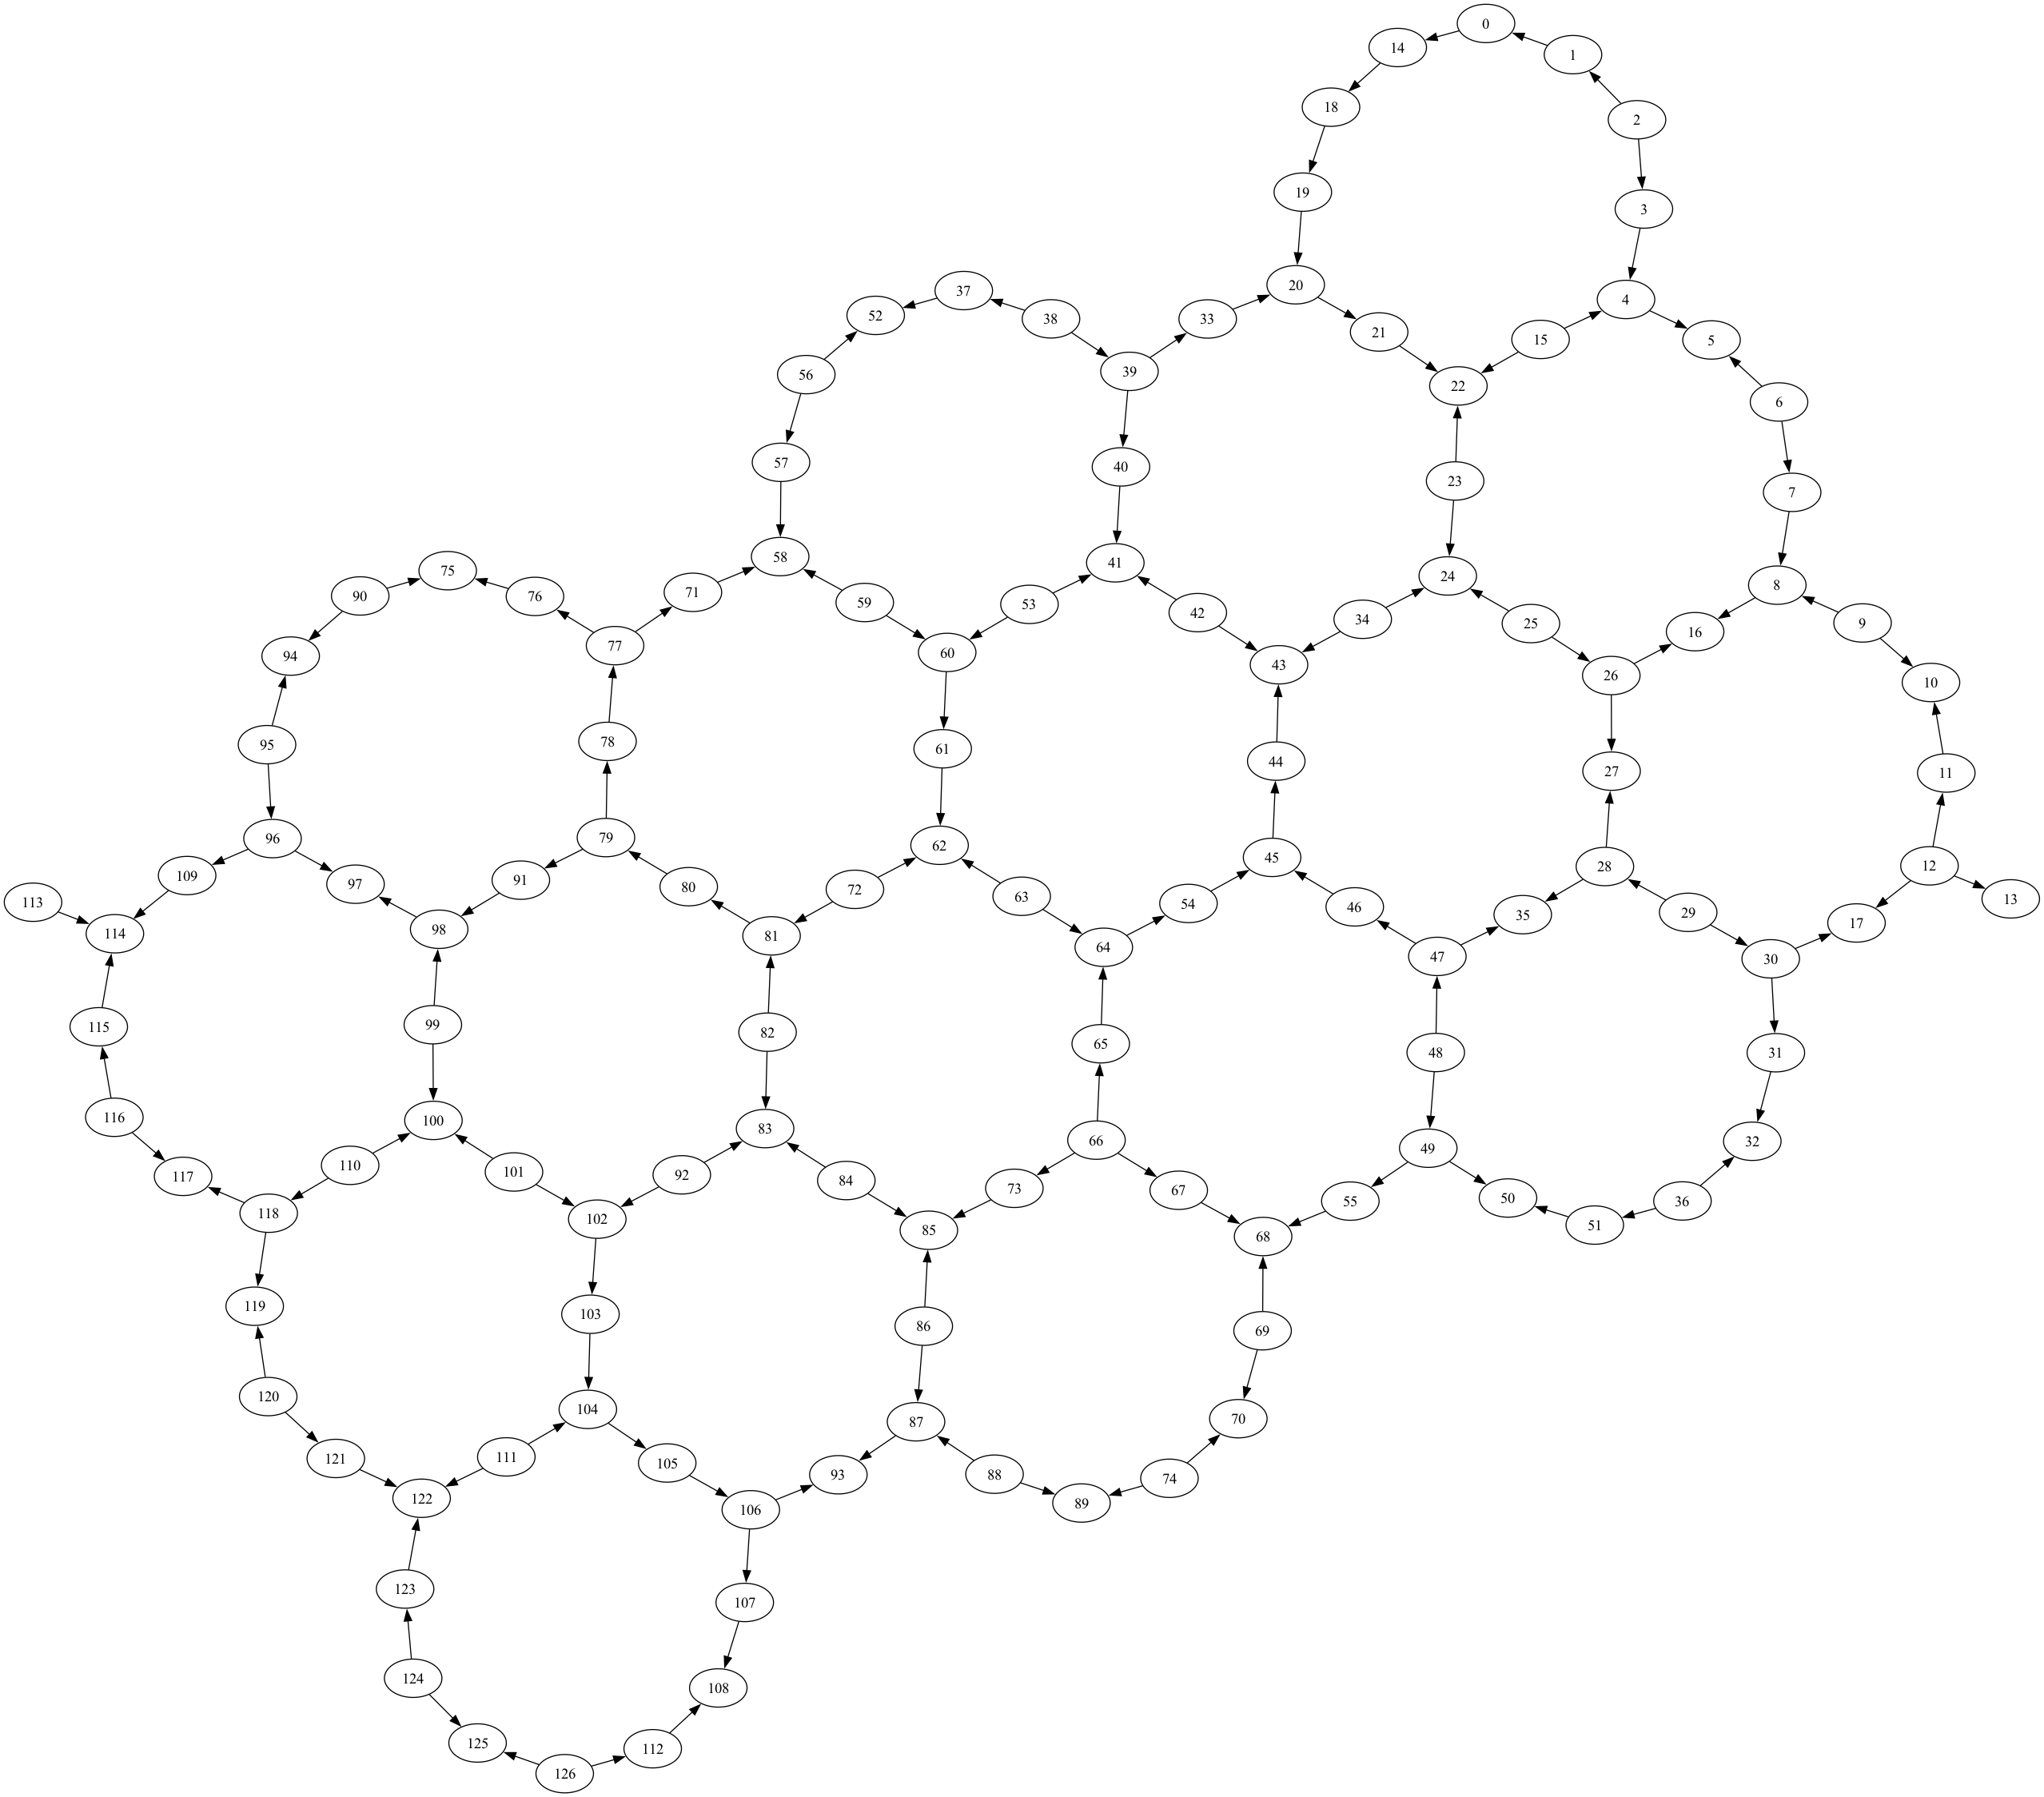

In [8]:
# This function requires that Graphviz is installed. If you need to install Graphviz you can refer to:
# https://graphviz.org/download/#executable-packages for instructions.
try:
    fig = backend.coupling_map.draw()
except RuntimeError as ex:
    print(ex)
fig

## 3. Qubit properties

The Eagle device has 127 qubits.   Let us obtain the properties of some of them.  

In [9]:
for qn in range(backend.num_qubits):
    if (qn>=5):
        break
    print(f"{qn}: {backend.qubit_properties(qn)}")

0: QubitProperties(t1=0.000183686508736532, t2=0.00023613944465408068, frequency=4832100227.116953)
1: QubitProperties(t1=0.00048794378526038294, t2=9.007098375327869e-05, frequency=4736264354.075363)
2: QubitProperties(t1=0.00021247781834456527, t2=7.81037910324034e-05, frequency=4859349851.150393)
3: QubitProperties(t1=0.0002936462084765663, t2=0.00011400214529510604, frequency=4679749549.503852)
4: QubitProperties(t1=0.00044229440258559125, t2=0.0003181648356339447, frequency=4845872064.050596)


Let us calculate the median of T1 times of the qubits.   Please compare the result to the one shown for the device at the IBM Quantum Platfrom. 

In [10]:
t1s = [backend.qubit_properties(qq).t1 for qq in range(backend.num_qubits)]
f"Median T1: {(statistics.median(t1s)*10**6):.2f} \u03bcs"

'Median T1: 285.43 μs'

### 3.1 Exercise

Pease calculate the median of T2 times of the qubits. Try this on your own, but code has been added below for you to check yourself.

In [11]:
# Your code here

t2s = [backend.qubit_properties(qq).t2 for qq in range(backend.num_qubits)]
f"Median T2: {(statistics.median(t2s)*10**6):.2f} \u03bcs"

'Median T2: 173.10 μs'

###  3.2 Gate and readout errors

We now turn to gate errors. To begin with, we study the data structure of the target instance. It is a dictionary whose keys are operation names.  

In [12]:
target = backend.target
target.keys()

dict_keys(['measure', 'id', 'sx', 'delay', 'x', 'for_loop', 'rz', 'if_else', 'ecr', 'reset', 'switch_case'])

Its values are also dictionaries.  Let us look at some of the items of the value (dictionary) for the 'sx' operation.

In [13]:
for i, qq in enumerate(target['sx']):
    if (i>=5):
        break
    print(i, qq, target['sx'][qq])

0 (0,) InstructionProperties(duration=6e-08, error=0.0007401311759115297)
1 (1,) InstructionProperties(duration=6e-08, error=0.0003163759907528654)
2 (2,) InstructionProperties(duration=6e-08, error=0.0003183859004638003)
3 (3,) InstructionProperties(duration=6e-08, error=0.00042235914178831863)
4 (4,) InstructionProperties(duration=6e-08, error=0.011163151923589715)


Let us do the same for the 'ecr' and 'measure' operations.

In [14]:
for i, edge in enumerate(target['ecr']):
    if (i>=5):
        break
    print(i, edge, target['ecr'][edge])

0 (0, 14) InstructionProperties(duration=6.6e-07, error=0.01486295709788732)
1 (1, 0) InstructionProperties(duration=6.6e-07, error=0.015201590794522601)
2 (2, 1) InstructionProperties(duration=6.6e-07, error=0.00697838102630724)
3 (2, 3) InstructionProperties(duration=6.6e-07, error=0.008075067943986797)
4 (3, 4) InstructionProperties(duration=6.6e-07, error=0.0630164507876913)


In [15]:
for i, qq in enumerate(target['measure']):
    if (i>=5):
        break
    print(i, qq, target['measure'][qq])

0 (0,) InstructionProperties(duration=1.6e-06, error=0.0078125)
1 (1,) InstructionProperties(duration=1.6e-06, error=0.155029296875)
2 (2,) InstructionProperties(duration=1.6e-06, error=0.057373046875)
3 (3,) InstructionProperties(duration=1.6e-06, error=0.02880859375)
4 (4,) InstructionProperties(duration=1.6e-06, error=0.01318359375)


As you can see, the errors of readout tend to be larger than those of the 2-qubit operation, which in turn tend to be larger than the 1-qubit operation.  

Having understood the data structures, we are ready to calculate the median errors for the 'sx' and the 'ecr' gates. Again, please compare the results with the ones shown for the device at the IBM Quantum Platfrom. 

In [16]:
sx_errors = [inst_prop.error for inst_prop in target['sx'].values()]
f"Median SX error: {(statistics.median(sx_errors)):.3e}"

'Median SX error: 2.277e-04'

In [17]:
ecr_errors = [inst_prop.error for inst_prop in target['ecr'].values()]
f"Median ECR error: {(statistics.median(ecr_errors)):.3e}"

'Median ECR error: 6.895e-03'

## 4. Appendix

A popular feature of Qiskit is its visualization capability. It includes circuit visualizers, state and distribution visualizers, and target visualizer.   You already used the first two in the previous jupyter notebooks.   Let us use some capabilities of the target visualizer. 

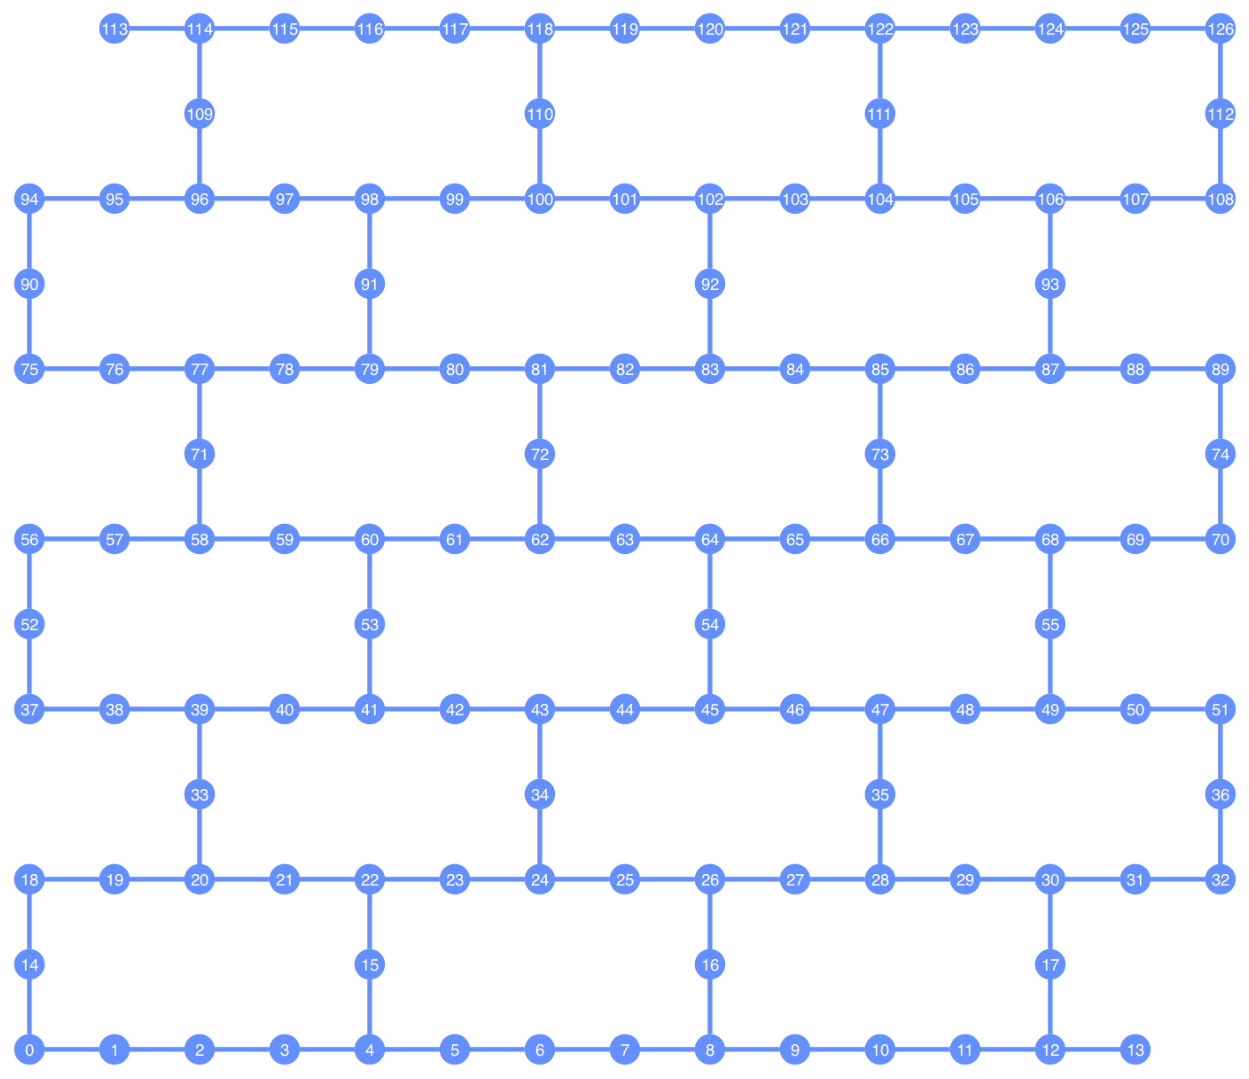

In [22]:
from qiskit.visualization import plot_gate_map

plot_gate_map(backend, font_size=14)

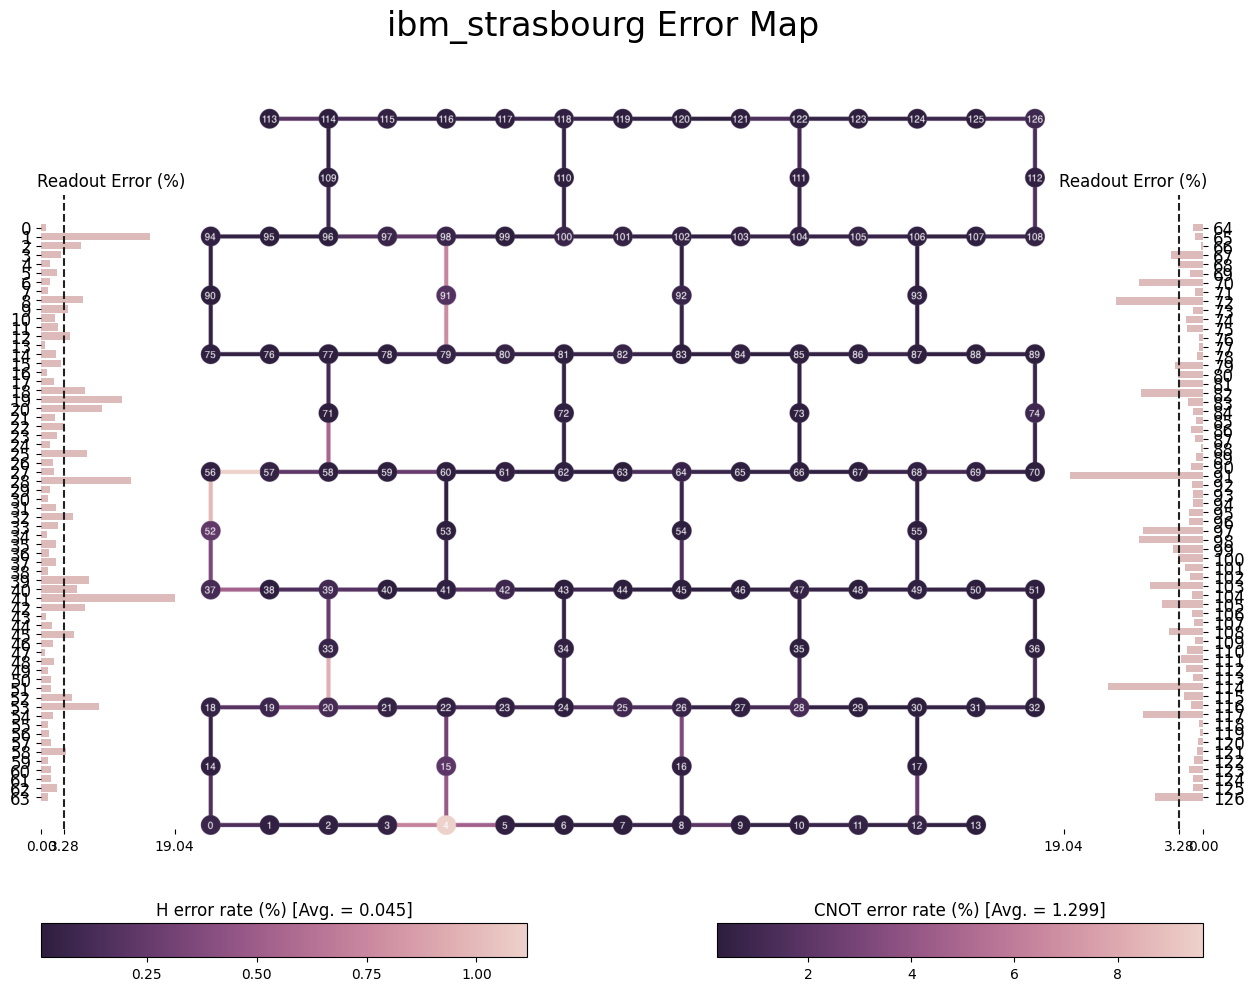

In [23]:
from qiskit.visualization import plot_error_map

plot_error_map(backend)

In [24]:
#Check Qiskit version
import qiskit
qiskit.__version__

'2.0.2'